In [ ]:
!pip install torchdyn
!pip install torchcfm
!pip install clean-fid

# Flow Matching

In [70]:
import os
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from tqdm import trange
import wandb

from torchdyn.core import NeuralODE
from torchcfm.models.unet.unet import UNetModelWrapper

In [ ]:
device = torch.device("cuda")

In [ ]:
def warmup_lr(step, WARMUP=5000):
    """Simple warmup schedule from 0 to initial LR over first WARMUP steps."""
    return min(step, WARMUP) / WARMUP

def infiniteloop(dataloader):
    """Creates an infinite iterator over a given dataloader."""
    while True:
        for x, _ in dataloader:
            yield x

@torch.no_grad()
def generate_samples(model,
                     savedir="./results_mnist/",
                     step_=0,
                     total_steps=100,
                     net_="normal",
                     plot=False):
    """
    Generate and save 32 unconditional MNIST samples at 28×28 resolution.
    """
    model.eval()
    model_ = copy.deepcopy(model)

    node_ = NeuralODE(model_, solver="euler", sensitivity="adjoint").to(device)

    # Generate random noise in shape (32, 1, 28, 28)
    z = torch.randn(32, 1, 28, 28, device=device)

    # Integrate from t=0 to t=1
    t_span = torch.linspace(0, 1, total_steps, device=device)
    traj = node_.trajectory(z, t_span)  # shape: [total_steps, 32, 1, 28, 28]

    # Final state
    x_gen = traj[-1].clamp(-1, 1)
    x_gen = x_gen / 2 + 0.5  # move from [-1,1] to [0,1]

    os.makedirs(savedir, exist_ok=True)
    img_path = f"{savedir}/{net_}_generated_FM_step_{step_}_total_{total_steps}.png"
    save_image(x_gen, img_path, nrow=8)

    if plot:
        import matplotlib.pyplot as plt
        grid = make_grid(x_gen, nrow=8)
        plt.figure(figsize=(8, 8))
        # For grayscale, we can do cmap="gray"
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray")
        plt.title(f"MNIST Gen: {net_} | step={step_}")
        plt.axis("off")
        plt.show()

    model.train()

def ema(source, target, decay=0.9999):
    """EMA update of target's params from source."""
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for k in source_dict.keys():
        target_dict[k].data.copy_(
            target_dict[k].data * decay + source_dict[k].data * (1 - decay)
        )


In [ ]:
############################
# 2) MNIST Data Loader
############################
def get_mnist_dataloader(batch_size=64):
    transform = transforms.Compose([
        # NO RESIZE -> keep 28×28
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Single-channel normalization
    ])

    mnist_train = datasets.MNIST(
        root="./data_mnist",
        train=True,
        transform=transform,
        download=True
    )
    loader = DataLoader(
        mnist_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        drop_last=True,
        pin_memory=True
    )
    return loader

In [ ]:
###########################
# 3) Define U-Net for 1×28×28
############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example: smaller than your CelebA net.
# For 28×28, let's do channel_mult=[1,2] or [1,2,2], etc.
# If you want attention at 14×14, set attention_resolutions="14".
# If you're OK with no attention, set it to "" or None.
net_model = UNetModelWrapper(
    dim=(1, 28, 28),      # 1 channel, 28×28
    num_res_blocks=2,
    num_channels=64,      # smaller base than 128, since MNIST is easier
    channel_mult=[1, 2],  # just one downsampling: 28->14
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.05,
).to(device)

ema_model = copy.deepcopy(net_model)

# Print model size
model_size = sum(p.numel() for p in net_model.parameters())
print("Model params: %.2f M" % (model_size / 1024 / 1024))


In [ ]:
############################
# 4) Flow Matching Trainer
############################
import torch.nn as nn

def train_flowmatching_mnist(
    TOTAL_STEPS=50000,
    BATCH_SIZE=64,
    LR=2e-4,
    GRAD_CLIP=1.0,
    SAVE_STEP=1000,
    WARMUP=5000
):
    mnist_loader = get_mnist_dataloader(batch_size=BATCH_SIZE)
    data_loop = infiniteloop(mnist_loader)

    optimizer = torch.optim.Adam(net_model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lr_lambda=lambda s: warmup_lr(s, WARMUP=WARMUP)
    )

    loss_fn = nn.MSELoss()

    # Close previous W&B run if present
    if wandb.run is not None:
        wandb.finish()
    wandb.init(project="MNIST-FM-28x28")

    pbar = trange(TOTAL_STEPS, desc="FlowMatching", dynamic_ncols=True)
    for step in pbar:
        optimizer.zero_grad()

        x_1 = next(data_loop).to(device)   # shape: (B, 1, 28, 28)
        x_0 = torch.randn_like(x_1)        # shape: (B, 1, 28, 28)

        B = x_1.size(0)
        t = torch.rand((B, 1), device=device).view(B, 1, 1, 1)
        x_t = t * x_1 + (1 - t) * x_0
        v_target = x_1 - x_0

        # Forward
        t_flat = t.squeeze()
        v_predict = net_model(t_flat, x_t)
        loss = loss_fn(v_predict, v_target)

        # Backward + clip
        loss.backward()
        nn.utils.clip_grad_norm_(net_model.parameters(), GRAD_CLIP)
        optimizer.step()
        scheduler.step()

        # EMA update
        ema(net_model, ema_model)

        # Logging
        wandb.log({"train_loss": loss.item(), "step": step})
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # Save periodically
        if SAVE_STEP > 0 and step > 0 and (step % SAVE_STEP == 0):
            os.makedirs("./checkpoints_mnist/", exist_ok=True)

            generate_samples(
                net_model,
                step_=step,
                savedir="./checkpoints_mnist/img/normal/",
                total_steps=100,
                net_="normal"
            )
            generate_samples(
                ema_model,
                step_=step,
                savedir="./checkpoints_mnist/img/ema/",
                total_steps=100,
                net_="ema"
            )

            ckpt_path = f"./checkpoints_mnist/fm_mnist_step_{step}.pth"
            torch.save({
                "net_model": net_model.state_dict(),
                "ema_model": ema_model.state_dict(),
                "sched": scheduler.state_dict(),
                "optim": optimizer.state_dict(),
                "step": step,
            }, ckpt_path)
            wandb.save(ckpt_path)

    print("Training completed!")
    wandb.finish()


In [ ]:
############################
# 5) Run Training
############################
if __name__ == "__main__":
    train_flowmatching_mnist(
        TOTAL_STEPS=60001,
        BATCH_SIZE=64,
        LR=2e-4,
        GRAD_CLIP=1.0,
        SAVE_STEP=1000,
        WARMUP=3000
    )

# Flow Generator Matching

In [ ]:
!pip install zuko
!pip install matplotlib
!pip install torchdiffeq
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchcfm

In [78]:
import torch
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchcfm.models.unet import UNetModel
import torchdiffeq
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

from torchdiffeq import odeint

In [79]:
wandb.init(
    project="Flow-Generator-Matching",
    name="FGM-MNIST-Multistep-Distillation",
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: danilkes (makriot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
### One step Flow Generator Matching
MULTISTEP_K = 1

### Multistep Distillation
# MULTISTEP_K = 4

In [82]:
class UnconditionalFlowLoss:
    """
    Adaptation of your Two-Loss approach, but no class_condition and no labels.
    """

    def __init__(self, sigma_min: float = 0.001):
        super().__init__()
        self.sigma_min = sigma_min
        self.epsilon = 1e-5
        self.device = device

    def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Linear interpolation between x0 -> x1 at times t in [0,1].
        """
        # Reshape t so it can broadcast over HxW as well
        while t.dim() < x.dim():
            t = t[..., None]
        # Interpolate from x0 to x1
        return (1 - (1 - self.sigma_min) * t) * x + t * x_1

    def loss_flow_matching(
        self,
        Online_v_t: nn.Module,
        Pretrained_v_t: nn.Module,
        Generator: nn.Module,
        batch_size: int = 10,
    ) -> torch.Tensor:
        """
        Trains the 'Online_v_t' to replicate the known pretrained vector field
        along the trajectory induced by the current Generator in [t=0..1].
        """
        t = (torch.rand(1, device=self.device) + torch.arange(10 * batch_size, device=self.device) / (10 * batch_size)) % (1 - self.epsilon)
        t = t[:, None]
        t_steps = torch.linspace(0, 1, MULTISTEP_K, device=self.device)
        class_condition = torch.tensor([x for x in range(10)] * batch_size, device=self.device)

        z = torch.randn(10 * batch_size, 1, 28, 28, device=self.device)

        with torch.no_grad():
            traj = torchdiffeq.odeint(
                lambda _t, _x: Generator(_t, _x, class_condition),
                z,
                t_steps,
                atol=1e-4,
                rtol=1e-4,
                method="euler",
            )

        x_0 = traj[-1]
        psi_t = self.psi_t(z, x_0, t)

        d_psi = x_0 - (1 - self.sigma_min) * z
        online_train = Online_v_t(t[:, 0], psi_t, class_condition)

        loss_flow_matching = torch.mean((online_train - d_psi) ** 2)

        # Free up GPU memory
        torch.cuda.empty_cache()

        return loss_flow_matching

    def loss_generator_matching(
        self,
        Online_v_t: nn.Module,
        Pretrained_v_t: nn.Module,
        Generator: nn.Module,
        batch_size: int = 10,
    ):
        """
        Given the current Online_v_t, train the generator so that
        G(z) matches the final sample we'd get by multi-step integration
        of Pretrained_v_t from t=0..1 starting at z.
        """
        t = (torch.rand(1, device=self.device) + torch.arange(10 * batch_size, device=self.device) / (10 * batch_size)) % (1 - self.epsilon)
        t = t[:, None]
        t_steps = torch.linspace(0, 1, MULTISTEP_K, device=self.device)
        class_condition = torch.tensor([x for x in range(10)] * batch_size, device=self.device)

        z = torch.randn(10 * batch_size, 1, 28, 28, device=self.device)

        traj = torchdiffeq.odeint(
            lambda _t, _x: Generator(_t, _x, class_condition),
            z,
            t_steps,
            atol=1e-4,
            rtol=1e-4,
            method="euler",
        )

        x_0 = traj[-1]

        psi_t = self.psi_t(z, x_0, t)
        d_psi = x_0 - (1 - self.sigma_min) * z

        pre_train = Pretrained_v_t(t[:, 0], psi_t, class_condition)
        online_train = Online_v_t(t[:, 0], psi_t, class_condition)

        l1 = torch.mean((pre_train - online_train) ** 2)
        l2 = torch.mean(2 * ((pre_train - online_train) * (online_train - d_psi)))

        # Free up GPU memory
        torch.cuda.empty_cache()

        return l1 + l2, x_0

In [83]:
Pretrained_v_t = UNetModelWrapper(
    dim=(1, 28, 28),      # 1 channel, 28×28
    num_res_blocks=2,
    num_channels=64,      # smaller base than 128, since MNIST is easier
    channel_mult=[1, 2],  # just one downsampling: 28->14
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.05,
    num_classes=10,    # for digits 0..9
    class_cond=True,
).to(device)

chkp = torch.load("fm_mnist_cond_step_60000.pth", weights_only=False)
Pretrained_v_t.load_state_dict(chkp["ema_model"])

# Online_v_t: same dimension as your pretrained vector field
Online_v_t = UNetModelWrapper(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=[1, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.05,
    num_classes=10,    # for digits 0..9
    class_cond=True,
).to(device)

Online_v_t.load_state_dict(Pretrained_v_t.state_dict())

Generator = UNetModelWrapper(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=[1, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.0,
    num_classes=10,    # for digits 0..9
    class_cond=True,
).to(device)


for p in Pretrained_v_t.parameters():
    p.requires_grad = False
Pretrained_v_t.eval()
#K = 1
#Generator = KStepGenerator(v_net=small_unet, K=K).to(device)

# Gen_ema = copy.deepcopy(Generator)
# Online_ema = copy.deepcopy(Online_v_t)

model_size = sum(p.numel() for p in Generator.parameters())
print("Generator model params: %.2f M" % (model_size / 1024 / 1024))

model_size_pretrain = sum(p.numel() for p in Pretrained_v_t.parameters())
print("Original FM model params: %.2f M" % (model_size_pretrain / 1024 / 1024))

model_size_online = sum(p.numel() for p in Online_v_t.parameters())
print("Online FM model params: %.2f M" % (model_size_online / 1024 / 1024))

Generator model params: 3.81 M
Original FM model params: 3.81 M
Online FM model params: 3.81 M


In [ ]:
from tqdm import tqdm
import datetime

def train_fgm():

    # 3) Define the optimizers and set up the main training loop
    optimizer_online = torch.optim.Adam(Online_v_t.parameters(), lr=2e-5, betas=(0.0, 0.999))
    optimizer_gen    = torch.optim.Adam(Generator.parameters(),  lr=2e-5, betas=(0.0, 0.999))

    flow_loss = UnconditionalFlowLoss(sigma_min=0.0)

    n_epochs = 20000  # or however many iterations you want
    log_interval = 200
    save_interval = 1000

    # Wrap your range(...) with tqdm(...) to get a progress bar
    for epoch in (pbar := tqdm(range(n_epochs), desc="Distillation Training")):

        loss_FM, loss_GM = 0, 0
        ##################################################
        # Step (a): Freeze Generator, train Online_v_t
        ##################################################
        for p in Generator.parameters():
            p.requires_grad = False
        for p in Online_v_t.parameters():
            p.requires_grad = True

        Generator.eval()
        Online_v_t.train()
        
        loss_flow_matching = flow_loss.loss_flow_matching(
            Online_v_t=Online_v_t,
            Pretrained_v_t=Pretrained_v_t,
            Generator=Generator,
            batch_size=10)
        optimizer_online.zero_grad()

        loss_flow_matching.backward()
        optimizer_online.step()

        loss_FM += loss_flow_matching.item()

        ##################################################
        # Step (b): Freeze Online_v_t, train Generator
        ##################################################
        for p in Generator.parameters():
            p.requires_grad = True
        for p in Online_v_t.parameters():
            p.requires_grad = False

        Generator.train()
        Online_v_t.eval()

        loss_generator_matching, image_gen = flow_loss.loss_generator_matching(
            Online_v_t=Online_v_t,
            Pretrained_v_t=Pretrained_v_t,
            Generator=Generator,
            batch_size=10)
        optimizer_gen.zero_grad()

        loss_generator_matching.backward()
        optimizer_gen.step()

        loss_GM += loss_generator_matching.item()

        pbar.set_description(f"Distillation Training: "
                                 f"Iter {epoch:05d} | "
                                 f"Online FM Loss: {loss_FM:.6f} | "
                                 f"Generator Matching Loss: {loss_GM:.6f}")
        
        wandb.log({
            "Online_FM_Loss": loss_FM,
            "Generator_Matching_Loss": loss_GM,
            "step": epoch
        })

        # Log / plot periodically
        if epoch % log_interval == 0:
            Generator.eval()
            print(f"Iter {epoch:05d} | "
                f"Online FM Loss: {loss_FM:.6f} | "
                f"Generator Matching Loss: {loss_GM:.6f}")
            
            class_condition = torch.tensor([x for x in range(10)], device=device)

            z = torch.randn(10, 1, 28, 28, device=device)
            t_steps = torch.linspace(0, 1, 50, device=device) 

            with torch.no_grad():
                traj = torchdiffeq.odeint(
                    lambda _t, _x: Pretrained_v_t(_t, _x, class_condition),
                    z,
                    t_steps,
                    rtol=1e-5, atol=1e-5,
                    method="euler",
                )

            grid_gen = make_grid(traj[-1], nrow=5, value_range=(-1, 1))
            grid_gen = (grid_gen.clamp(-1, 1) + 1) / 2.0  # Now in [0,1]
            plt.figure(figsize=(6,6))
            plt.imshow(grid_gen.permute(1,2,0).cpu().numpy())
            plt.title("Ref final from Pretrained ODE (batch snippet)")
            plt.axis("off")
            plt.show()

            grid_ref = make_grid(image_gen[:10].clamp(-1, 1), nrow=5, value_range=(-1,1))
            grid_ref = (grid_ref.clamp(-1, 1) + 1) / 2.0  # Now in [0,1]
            plt.figure(figsize=(6,6))
            plt.imshow(grid_ref.permute(1,2,0).cpu().numpy())
            plt.title("Multistep K=4 samples")
            plt.axis("off")
            plt.show()
            
            with torch.no_grad():
                traj = torchdiffeq.odeint(
                    lambda _t, _x: Online_v_t(_t, _x, class_condition),
                    z,
                    t_steps,
                    rtol=1e-5, atol=1e-5,
                    method="euler",
                )

            grid_ref = make_grid(traj[-1], nrow=5, value_range=(-1,1))
            grid_ref = (grid_ref.clamp(-1, 1) + 1) / 2.0  # Now in [0,1]
            plt.figure(figsize=(6,6))
            plt.imshow(grid_ref.permute(1,2,0).cpu().numpy())
            plt.title("Online model samples")
            plt.axis("off")
            plt.show()

            Generator.train()

        if epoch % save_interval == 0 and epoch != 0:
            dataset_name = "mnist_cond_multistep"

            if os.path.exists(f"./checkpoints/") == False:
                os.makedirs(f"./checkpoints/")

            if os.path.exists(f"./checkpoints/{dataset_name}/") == False:
                os.makedirs(f"./checkpoints/{dataset_name}/")

            torch.save(Pretrained_v_t.state_dict(), f"./checkpoints/{dataset_name}/Pretrained_v_t.pt")
            torch.save(Online_v_t.state_dict(), f"./checkpoints/{dataset_name}/Online_v_t.pt")
            torch.save(Generator.state_dict(), f"./checkpoints/{dataset_name}/Generator.pt")

In [85]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

Distillation Training:   0%|          | 0/20000 [00:00<?, ?it/s]

Distillation Training: Iter 00000 | Online FM Loss: 2.221051 | Generator Matching Loss: 0.036631:   0%|          | 0/20000 [00:01<?, ?it/s]

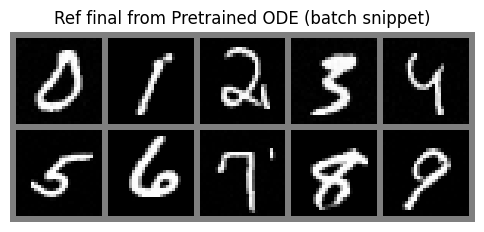

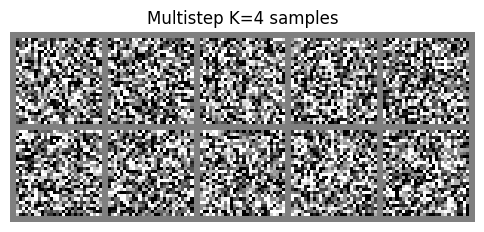

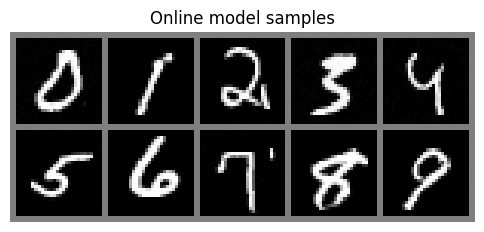

Distillation Training: Iter 00200 | Online FM Loss: 0.097938 | Generator Matching Loss: 1.072879:   1%|          | 200/20000 [03:21<5:08:12,  1.07it/s]

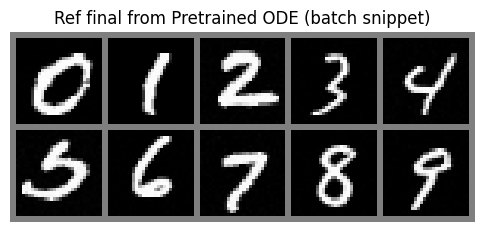

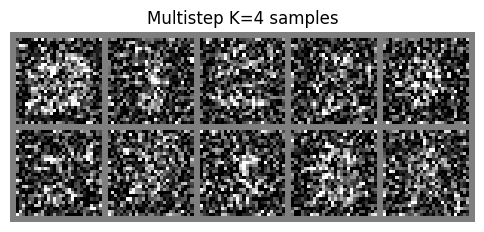

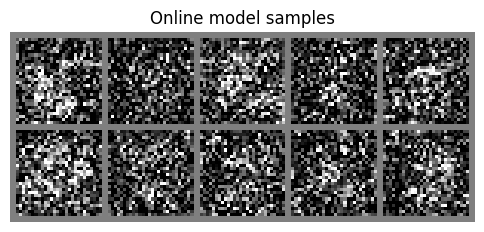

Distillation Training: Iter 00400 | Online FM Loss: 0.123000 | Generator Matching Loss: 0.286308:   2%|▏         | 400/20000 [06:41<5:11:31,  1.05it/s]

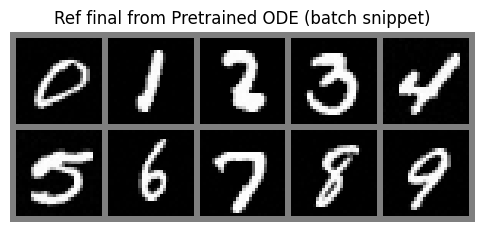

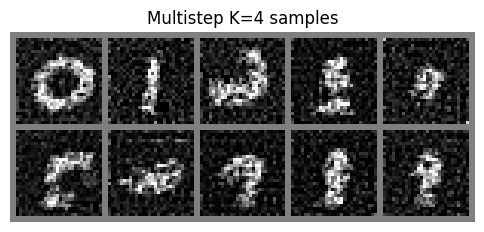

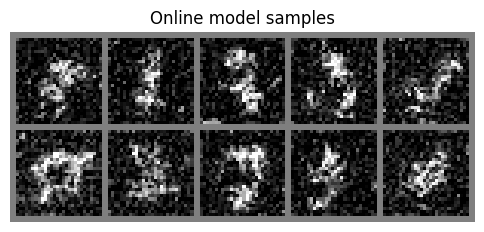

Distillation Training: Iter 00600 | Online FM Loss: 0.130501 | Generator Matching Loss: 0.083004:   3%|▎         | 600/20000 [10:01<5:04:58,  1.06it/s]

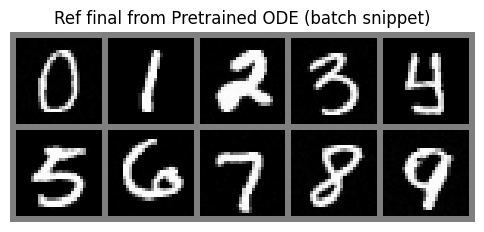

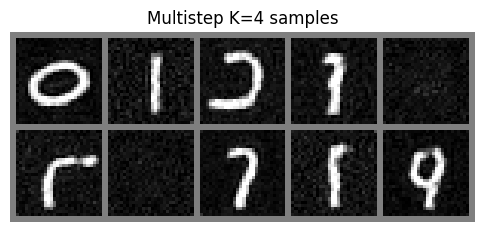

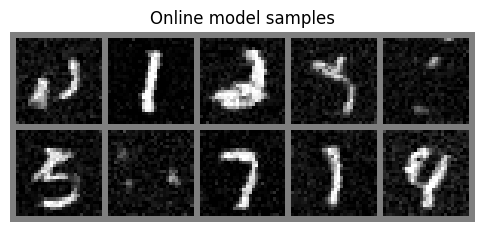

Distillation Training: Iter 00800 | Online FM Loss: 0.141220 | Generator Matching Loss: 0.047135:   4%|▍         | 800/20000 [13:22<5:15:10,  1.02it/s]

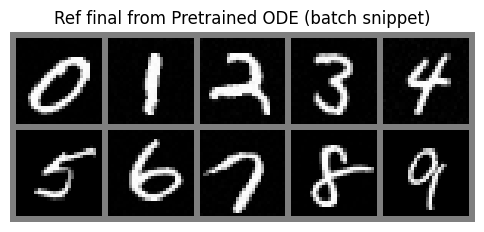

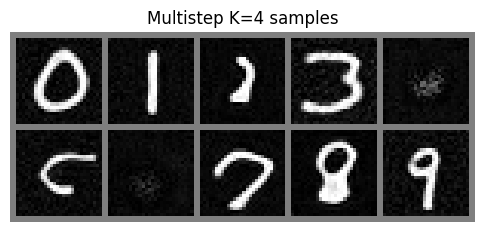

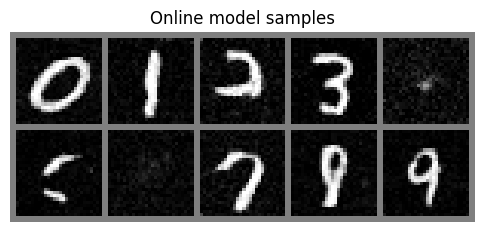

Distillation Training: Iter 01000 | Online FM Loss: 0.126905 | Generator Matching Loss: 0.033823:   5%|▌         | 1000/20000 [16:43<4:56:53,  1.07it/s]

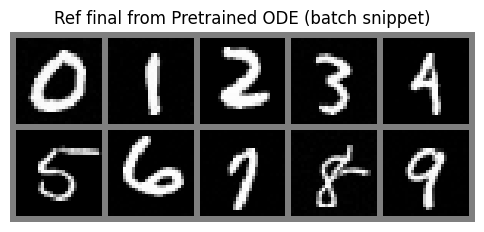

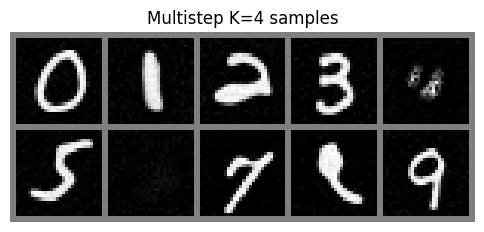

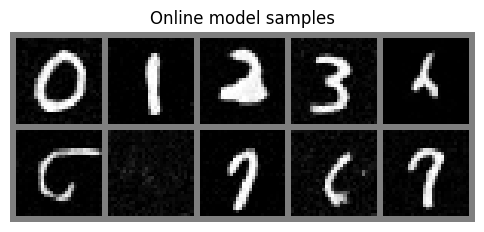

Distillation Training: Iter 01200 | Online FM Loss: 0.152977 | Generator Matching Loss: 0.017329:   6%|▌         | 1200/20000 [20:02<5:12:31,  1.00it/s]

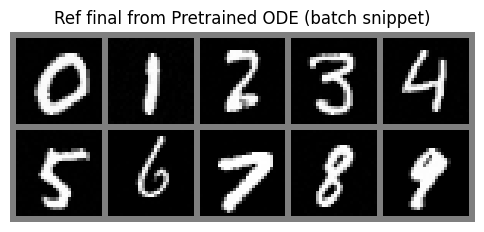

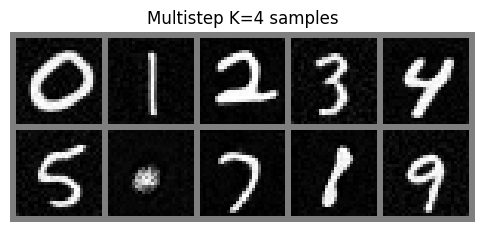

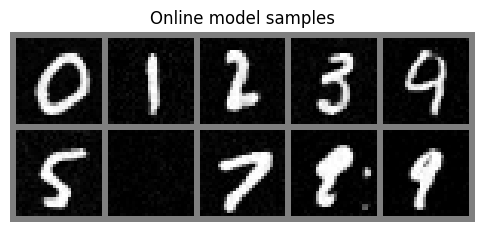

Distillation Training: Iter 01400 | Online FM Loss: 0.137225 | Generator Matching Loss: 0.024063:   7%|▋         | 1400/20000 [23:23<5:24:11,  1.05s/it]

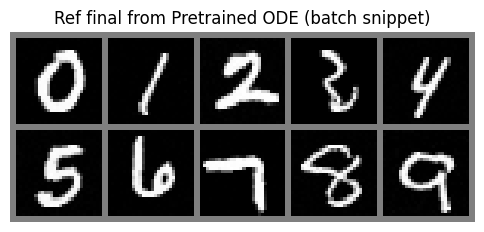

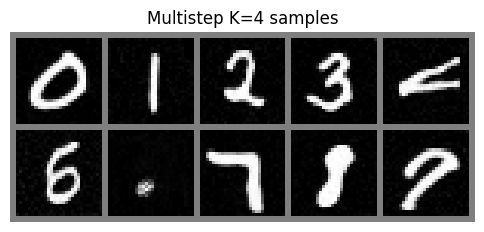

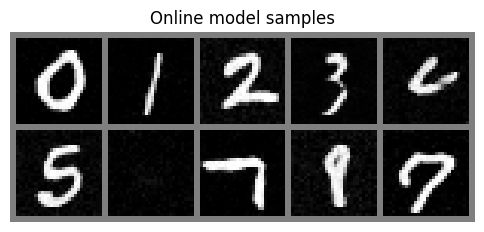

Distillation Training: Iter 01600 | Online FM Loss: 0.129295 | Generator Matching Loss: 0.018216:   8%|▊         | 1600/20000 [26:44<4:40:38,  1.09it/s]

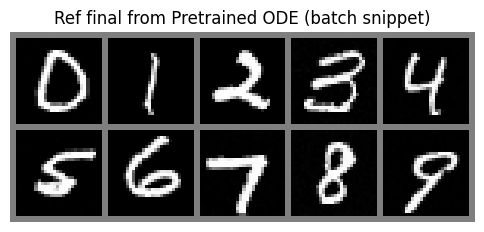

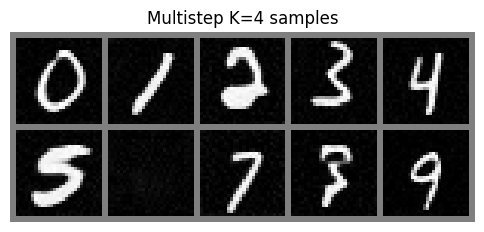

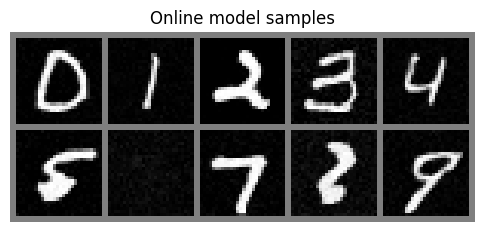

Distillation Training: Iter 01800 | Online FM Loss: 0.172171 | Generator Matching Loss: 0.015860:   9%|▉         | 1800/20000 [30:05<5:23:35,  1.07s/it]

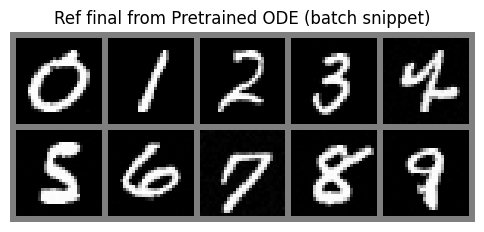

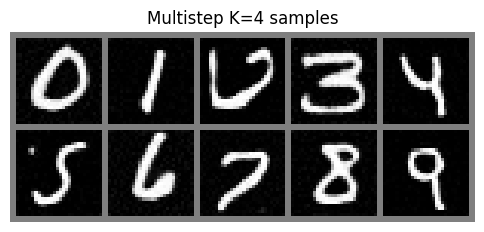

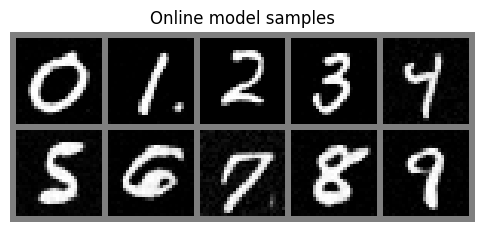

Distillation Training: Iter 02000 | Online FM Loss: 0.142325 | Generator Matching Loss: 0.013484:  10%|█         | 2000/20000 [33:26<5:05:58,  1.02s/it]

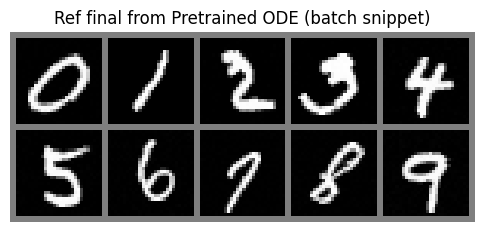

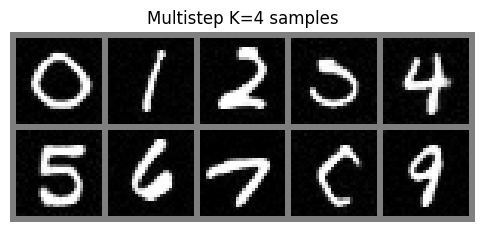

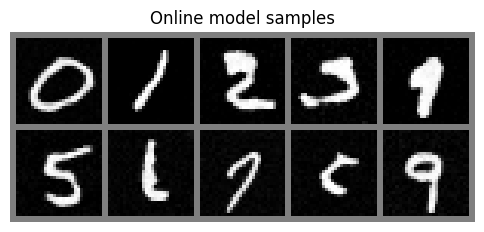

Distillation Training: Iter 02200 | Online FM Loss: 0.133409 | Generator Matching Loss: 0.011875:  11%|█         | 2200/20000 [36:47<4:48:38,  1.03it/s]

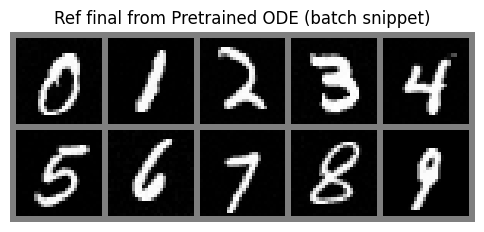

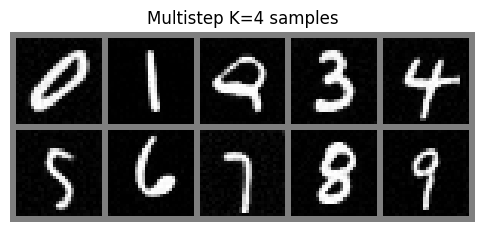

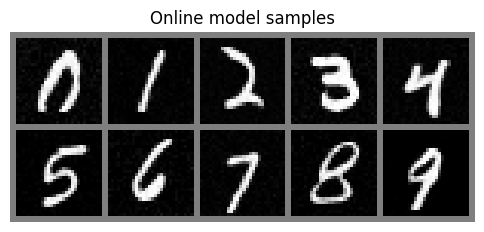

Distillation Training: Iter 02400 | Online FM Loss: 0.144939 | Generator Matching Loss: 0.007329:  12%|█▏        | 2400/20000 [40:07<5:06:56,  1.05s/it]

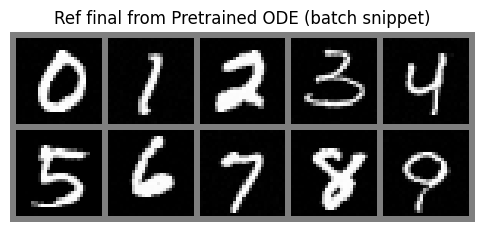

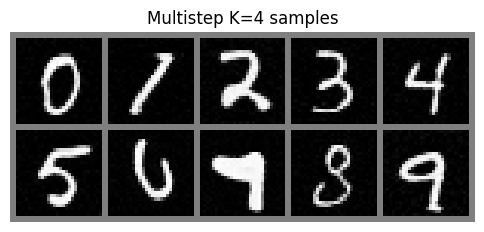

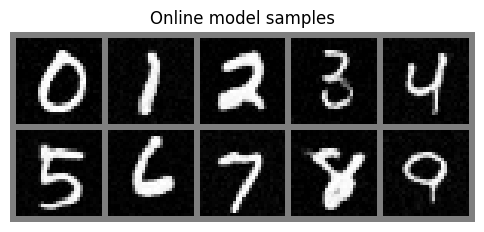

Distillation Training: Iter 02600 | Online FM Loss: 0.140767 | Generator Matching Loss: 0.008530:  13%|█▎        | 2600/20000 [43:28<4:54:54,  1.02s/it]

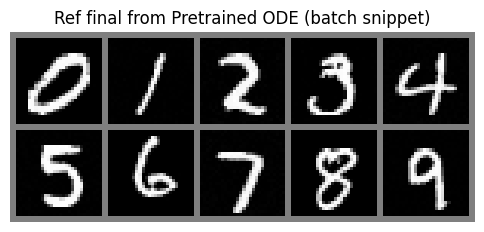

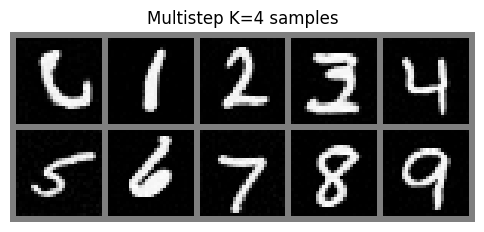

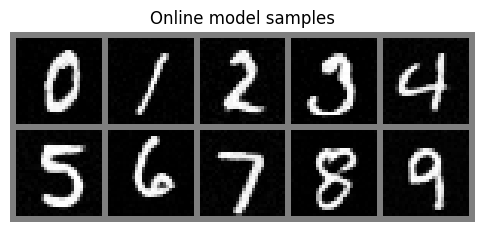

Distillation Training: Iter 02800 | Online FM Loss: 0.143074 | Generator Matching Loss: 0.009405:  14%|█▍        | 2800/20000 [46:50<4:49:12,  1.01s/it]

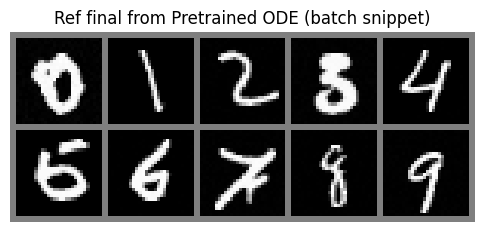

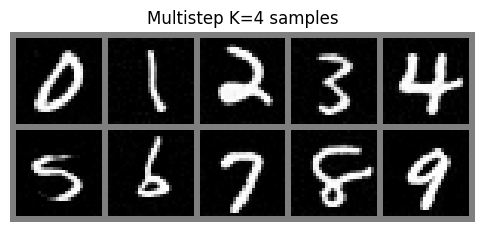

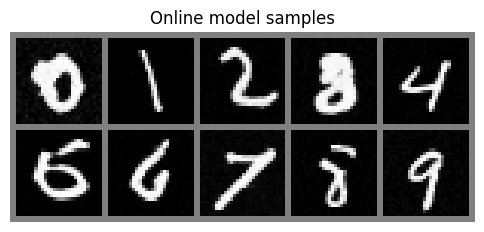

Distillation Training: Iter 03000 | Online FM Loss: 0.149173 | Generator Matching Loss: 0.007585:  15%|█▌        | 3000/20000 [50:10<4:45:24,  1.01s/it]

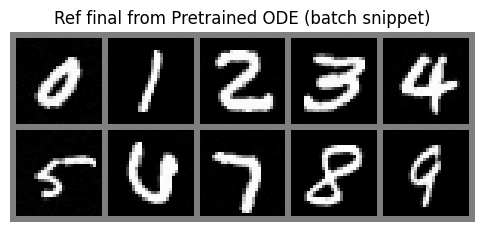

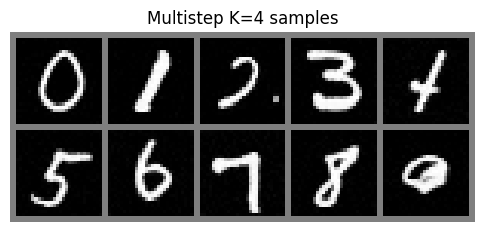

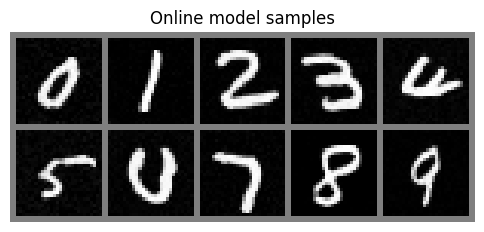

Distillation Training: Iter 03200 | Online FM Loss: 0.137721 | Generator Matching Loss: 0.009058:  16%|█▌        | 3200/20000 [53:31<4:38:02,  1.01it/s]

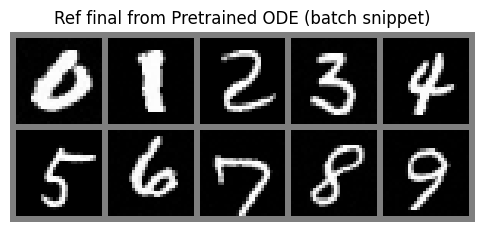

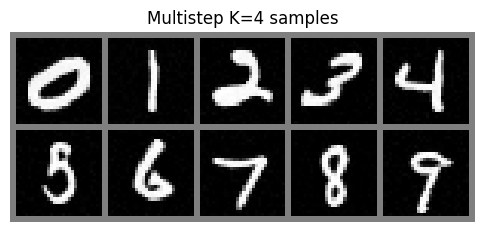

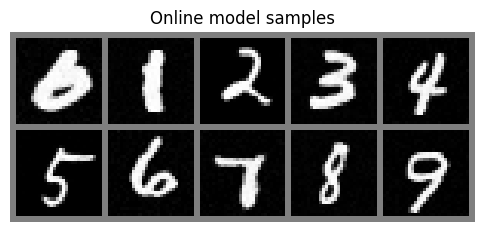

Distillation Training: Iter 03400 | Online FM Loss: 0.139254 | Generator Matching Loss: 0.006543:  17%|█▋        | 3400/20000 [56:53<4:37:25,  1.00s/it]

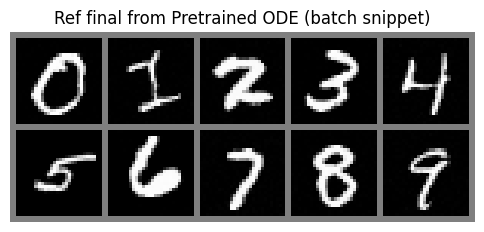

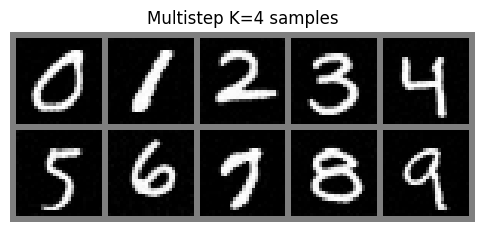

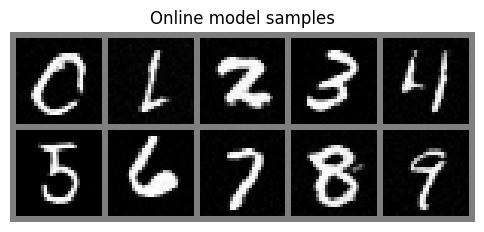

Distillation Training: Iter 03600 | Online FM Loss: 0.158248 | Generator Matching Loss: 0.009721:  18%|█▊        | 3600/20000 [1:00:14<4:24:50,  1.03it/s]

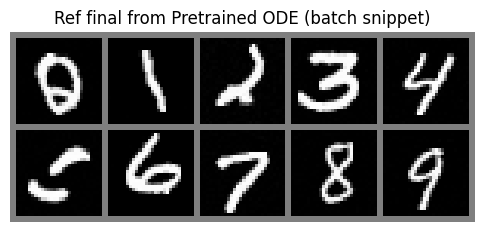

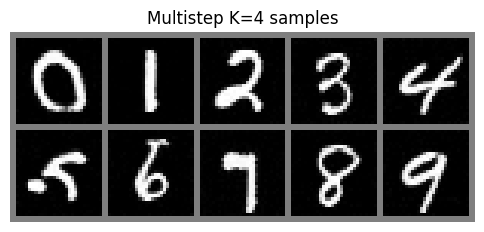

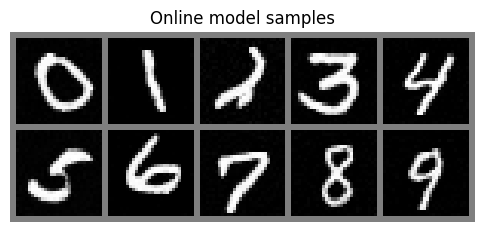

Distillation Training: Iter 03800 | Online FM Loss: 0.145869 | Generator Matching Loss: 0.007304:  19%|█▉        | 3800/20000 [1:03:35<5:04:39,  1.13s/it]

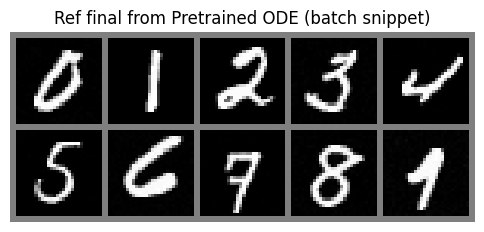

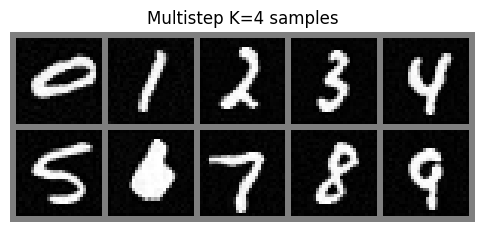

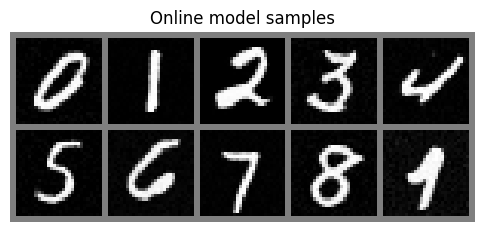

Distillation Training: Iter 03875 | Online FM Loss: 0.156838 | Generator Matching Loss: 0.011185:  19%|█▉        | 3876/20000 [1:04:52<4:29:52,  1.00s/it]


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fccb421e630>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fcc2db7e540, execution_count=86 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7fcc2db7d040, raw_cell="with HiddenPrints():
    train_fgm()

# train_fgm(.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bysda_beleriand/home/tohchukovda/skoltech/ML/final_project/fgm_mnist_cond_multistep.ipynb#X24sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
with HiddenPrints():
    train_fgm()

# FID

In [66]:
Pretrained_v_t = UNetModelWrapper(
    dim=(1, 28, 28),      # 1 channel, 28×28
    num_res_blocks=2,
    num_channels=64,      # smaller base than 128, since MNIST is easier
    channel_mult=[1, 2],  # just one downsampling: 28->14
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.05,
    num_classes=10,    # for digits 0..9
    class_cond=True,
).to(device)

# Online_v_t: same dimension as your pretrained vector field
Online_v_t = UNetModelWrapper(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=[1, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.05,
    num_classes=10,    # for digits 0..9
    class_cond=True,
).to(device)

Generator = UNetModelWrapper(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=[1, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="14",
    dropout=0.0,
    num_classes=10,    # for digits 0..9
    class_cond=True,
).to(device)

In [67]:
# Find last folder in checkpoints
import os
import datetime

dataset_name = 'mnist_cond_l2'

def find_last_folder():
    folders = os.listdir(f"./checkpoints/{dataset_name}")
    last_folder = sorted(folders)[-1]
    return last_folder

folder_lastest_checkpoint = find_last_folder()

print("Load checkpoint: ", folder_lastest_checkpoint)
Pretrained_v_t.load_state_dict(torch.load(f"./checkpoints/{dataset_name}/Pretrained_v_t.pt", weights_only=False, map_location=device))
Online_v_t.load_state_dict(torch.load(f"./checkpoints/{dataset_name}/Online_v_t.pt", weights_only=False, map_location=device))
Generator.load_state_dict(torch.load(f"./checkpoints/{dataset_name}/Generator.pt", weights_only=False, map_location=device))

Load checkpoint:  Pretrained_v_t.pt


<All keys matched successfully>

In [68]:
import os
import torch
from torchvision.utils import save_image
from tqdm import trange

def generate(model, N_STEPS=4, batch_size=50):
    N_SAMPLES = 10
    CONDITION = torch.tensor([x for x in range(10)] * batch_size, device=device)
    t_steps_solve = torch.linspace(0, 1, N_STEPS, device=device)

    # GENERATOR IMAGE
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            traj = torchdiffeq.odeint(
                lambda t, x: model(t, x, CONDITION),
                torch.randn(N_SAMPLES * batch_size, 1, 28, 28, device=device),
                t_steps_solve,
                atol=1e-4,
                rtol=1e-4,
                method="euler",
            )
    return traj[-1]

def generate_and_save_images(model, num_samples=1000, batch_size=50, output_dir='generated_images'):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    num_batches = num_samples // batch_size
    idx = 0
    for _ in trange(num_batches, desc="Generating images"):
        
        # generated = traj[-1].cpu()
        generated = generate(model)

        generated = (generated + 1) / 2  # Normalize to [0, 1]
        for img in generated:
            save_image(img, os.path.join(output_dir, f'{idx}.png'))
            idx += 1

def save_mnist_test_images(output_dir='mnist_test'):
    mnist_test = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
    )
    os.makedirs(output_dir, exist_ok=True)
    for idx in trange(len(mnist_test), desc="Saving MNIST test images"):
        img, _ = mnist_test[idx]
        img = (img + 1) / 2  # Normalize to [0, 1]
        save_image(img, os.path.join(output_dir, f'{idx}.png'))

# Generate images after training
generate_and_save_images(Generator, num_samples=1000, output_dir='generated_images')

# Save test MNIST images
save_mnist_test_images(output_dir='mnist_test')


Generating images:   0%|          | 0/20 [00:00<?, ?it/s]

Saving MNIST test images: 100%|██████████| 10000/10000 [00:06<00:00, 1597.85it/s]


In [ ]:
! python -m pytorch_fid generated_images mnist_test --device cuda